In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import networkx as nx

import argparse
import torch
import torch.nn as nn
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torch.nn.parameter import Parameter
import torch.nn as nn
import math

from torch.autograd import grad
import pandas as pd
import seaborn as sns

from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.decomposition import PCA

# Data Generation

burgers_equation simulate water velocity from Burger's equation using semi-implicit Euler schema

In [ ]:
def burgers_equation(nx = 1000, nt=500, tmax=1.5, ub = 1.0, lb = -1.0, nu=0.1):
    """
    Solve the Burger's equation: du/dt + u*du/dx = nu*d^2u/dx^2
    using implicit finite difference method

    Parameters:
        nx: number of spatial points
        nt: number of time steps
        tmax: maximum time
        ub: upper bound of the spatial domain
        lb: lower bound of the spatial domain
        nu: viscosity coefficient
    """
    # Set up grid
    L = ub - lb
    dx = L/nx
    dt = tmax/nt
    x = np.linspace(lb, ub, nx)
    t = np.linspace(0, tmax, nt)

    # Initialize solution array
    u = np.zeros((nt, nx))

    # Initial condition (sinusoidal wave)
    u[0, :] = -np.sin(np.pi*x)

    # Create sparse matrices for implicit scheme
    r = nu*dt/(dx**2)

    for n in range(0, nt-1):
        # Create coefficient matrix A_tilde
        main_diag = 1 + 2*r * np.ones(nx)
        upper_diag = -r * np.ones(nx-1)
        lower_diag = -r * np.ones(nx-1)

        A_tilde = diags([main_diag, upper_diag, lower_diag], [0, 1, -1], format='csr')

        # Create RHS vector
        b = u[n, :] - dt/(2*dx) * u[n, :] * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1))

        # Apply periodic boundary conditions
        b[0] = u[n, 0]
        b[-1] = u[n, -1]

        # Solve system
        u[n+1, :] = spsolve(A_tilde, b)

    return x, t, u

def plot_solution(x, t, u):
    """Plot the solution as a 2D heatmap and final time snapshot"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot heatmap
    im = ax1.pcolormesh(x, t, u, shading='auto')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_title("Burger's equation solution")
    plt.colorbar(im, ax=ax1)

    # Plot final time solution
    ax2.plot(x, u[-1, :], 'b-', label='Final time')
    ax2.plot(x, u[0, :], 'r--', label='Initial condition')
    ax2.set_xlabel('x')
    ax2.set_ylabel('u')
    ax2.legend()
    ax2.set_title('Solution at final time')

    plt.tight_layout()
    plt.show()

# Generate and plot solution
x, t, u = burgers_equation()

In [ ]:
np.random.seed(42)

u_rand = u + np.random.normal(0, 0.1, u.shape)

# Get random locations

get_chunks split the x axis into chunks, then in each chunk I randomly pick one sensor location. This avoid dense areas of sensors followed by empty areas of sensors.

In [ ]:
def get_chunks(x, num_sensors):
  len_chunks = int(len(x)/num_sensors)
  x_chunk=[]
  for chunk in range(num_sensors):
    x_chunk.append(x[chunk*len_chunks:(chunk+1)*len_chunks])
  return x_chunk

In [ ]:
n_nodes = 30

np.random.seed(42)

x_node = np.random.choice(x, n_nodes, replace=False)

#t = np.linspace(0,1.5,500)

x_node_indeces = np.where(np.isin(x,x_node))[0]

velocity = u_rand[:,x_node_indeces]

In [ ]:
def plot_3d_solution(x, t, u_pred, u_real):
    """Create multiple 3D visualizations of the solution"""
    # Create a meshgrid for plotting
    X, T = np.meshgrid(x, t)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 7))
    axes = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(2)]

    # Plot predictions and ground truth
    for i, (ax, u) in enumerate(zip(axes, [u_pred, u_real])):
        surf = ax.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(f'Surface Plot: {"Predictions" if i == 0 else "Ground Truth"}')

        # Add colorbar to the side of the respective subplot
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        # Adjust view angles
        ax.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()


Time series of the velocity at time step 0.

Text(0.5, 1.0, '')

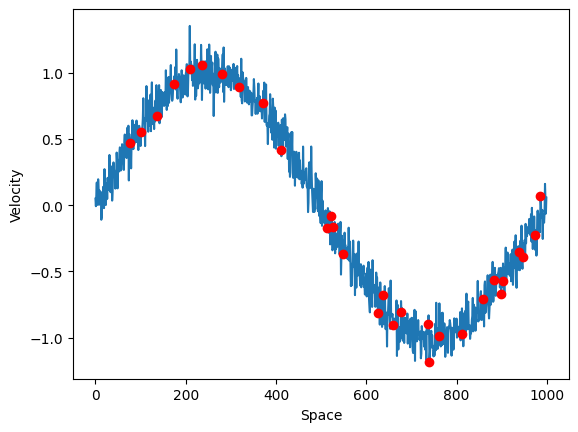

In [ ]:
plt.plot(u_rand[0,:])
plt.plot(x_node_indeces, u_rand[0,x_node_indeces], "ro" )
plt.xlabel("Space")
plt.ylabel("Velocity")
plt.title("")

Velocity of all sensors

<Axes: >

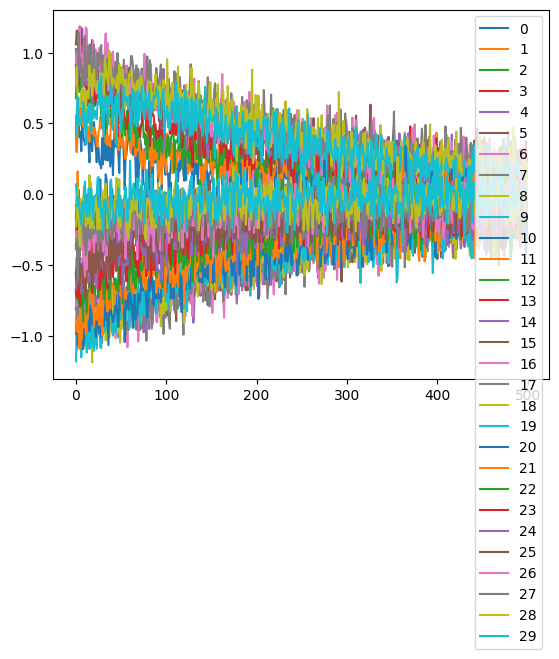

In [ ]:
pivoted_df_velocity = pd.DataFrame(velocity)
pivoted_df_velocity.plot()


# Adjacecncy matrix

Get the adjacency matrix by incorporating distance of the sensors and correlation of the time series velocity. I start with the set (graph with no edges) and then I add an edge if the two nodes are close enough (over a certain threshold) in terms of space and time series velocity. I keep adding edges by reducing the threshold until the graph is connected

In [ ]:
def adjacency_matrix(data, x_node):
    """
    Enhanced adjacency matrix construction incorporating both spatial and temporal correlations

    Args:
        data: velocity data of shape [t, n_nodes]
        x_node: spatial coordinates of nodes
        window_size: window for temporal correlation
        alpha: weight between spatial and temporal correlation
        spatial_threshold: threshold for spatial connections
        temporal_threshold: threshold for temporal connections
    """
    n_nodes = len(x_node)

    Ws = np.exp(-(x_node[:,np.newaxis] - x_node)**2/np.std(x_node)) - np.eye(len(x_node))

    A = Ws

    threshold = 1.0

    A_temp = A.copy()
    A_temp[A<=threshold] = 0

    G = nx.Graph(A_temp)

    while not nx.is_connected(G) and threshold>=0:

        threshold -= 0.01
        A_temp = A.copy()
        A_temp[A<=threshold] = 0
        G = nx.Graph(A_temp)

    return A_temp, threshold

In [ ]:
A, threshold = adjacency_matrix(velocity, x_node)

In [ ]:
threshold

0.9199999999999999

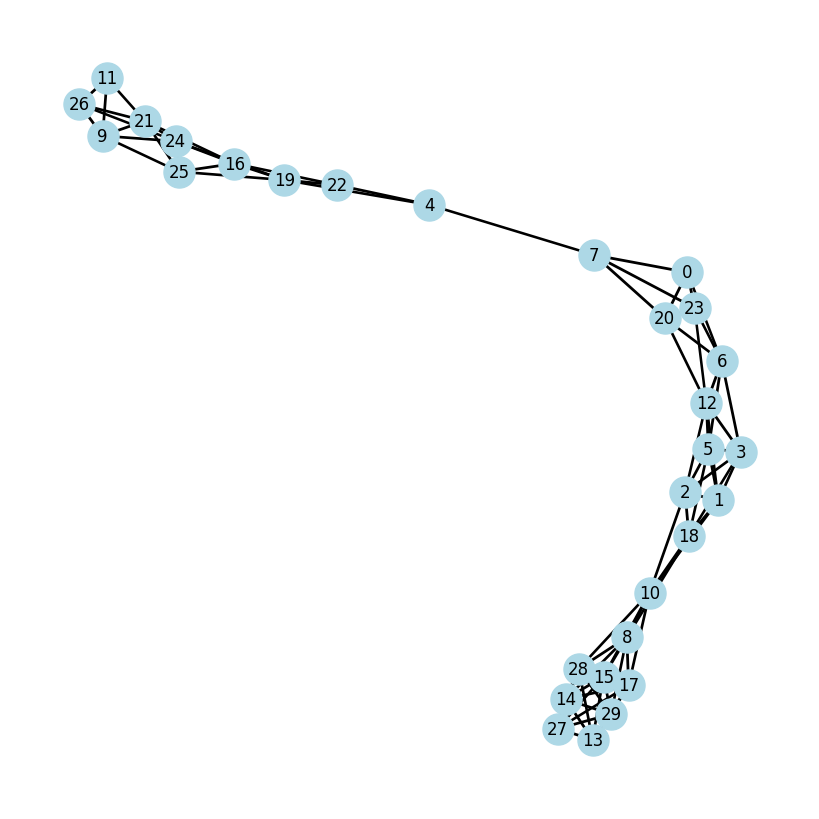

In [ ]:
G = nx.from_numpy_array(A)
pos = nx.spring_layout(G) #position of nodes in the graph

# Edge widths proportional to weights
weights = [G[u][v]['weight'] * 2 for u,v in G.edges()]  # Multiply by 2 to make more visible

plt.figure(figsize=(8,8))
nx.draw(G, pos, width=weights, with_labels=True,
       node_color='lightblue', node_size=500)
plt.show()

We have two graphs cluster since the velocity is positive for some sensors and megative for other sensors. Looking at the heatmap of the velocity below, we see that the sensors 0-15 have positive velocity, while sensors 16-29 have negative velocity. On y-axis there are sensors and on the x-axis the time

<Axes: >

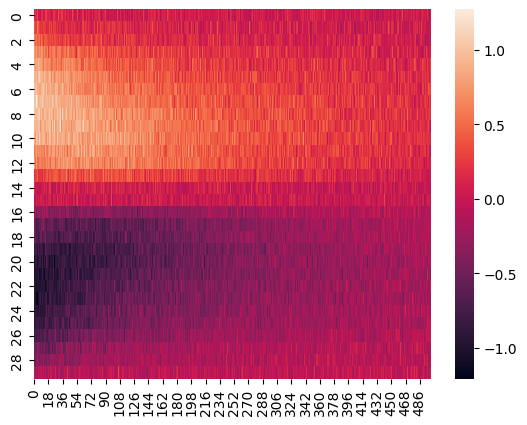

In [ ]:
sns.heatmap(velocity.T)

In [ ]:
nx.is_connected(G)

True

# Generation of mask

Block strategy: for each node, a sequence with a length in range [0, L/2] is selected as the imputation target with probability 40%.

In [ ]:
def block_mask(vel):

  mask = torch.ones_like(vel, dtype = torch.int)
  L = vel.shape[0]
  lb_range = L/2
  ub_range = L
  for node in range(vel.shape[1]):

    if np.random.binomial(1,0.4) == 1:
      random_length = np.random.randint(0, lb_range)
      init_val = np.random.randint(0,vel.shape[0]-1)
      mask[init_val:init_val+random_length, node] = 0

  #masked_nodes = [np.where(mask[t,:] == 0)[0] for t in range(mask.shape[0])]
  return mask

def mask_generation(vel, n_mask_train, n_mask_test):

    if isinstance(vel, np.ndarray):
        vel = torch.tensor(vel, dtype=torch.float32)

    mask_set_train = []

    for _ in range(n_mask_train):
        mask_set_train.append(block_mask(vel))

    # Convert each mask to a hashable type (nested tuples) for the set
    set_mask_train = set([tuple(map(tuple, mask.tolist())) for mask in mask_set_train])

    mask_set_test = []

    for _ in range(n_mask_test):  # Generate test masks avoiding data leakage
        mask = block_mask(vel)
        while tuple(map(tuple, mask.tolist())) in set_mask_train:
            mask = block_mask(vel)
        mask_set_test.append(mask)

    return mask_set_train, mask_set_test



In [ ]:
np.random.seed(42)

train_size = 8
test_size = 2

mask_train, mask_test = mask_generation(velocity, n_mask_train = train_size, n_mask_test = test_size)

visualization of the mask, missing values are the black blocks

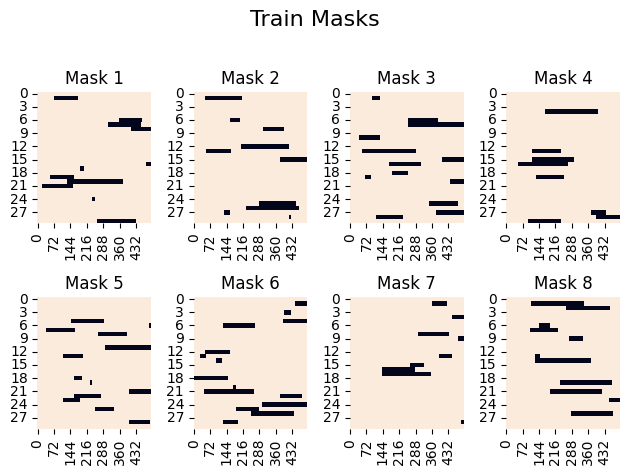

In [ ]:
fig, axes = plt.subplots(2,4)  # axes is a 2D array with shape (2, 3)
axes = axes.flatten()

fig.suptitle("Train Masks", fontsize=16)

# Plot each heatmap
for i, ax in enumerate(axes):
    sns.heatmap(mask_train[i].T, ax=ax, cbar=False)  # Transpose if needed
    ax.set_title(f"Mask {i + 1}")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the overall title

# Show the plots
plt.show()

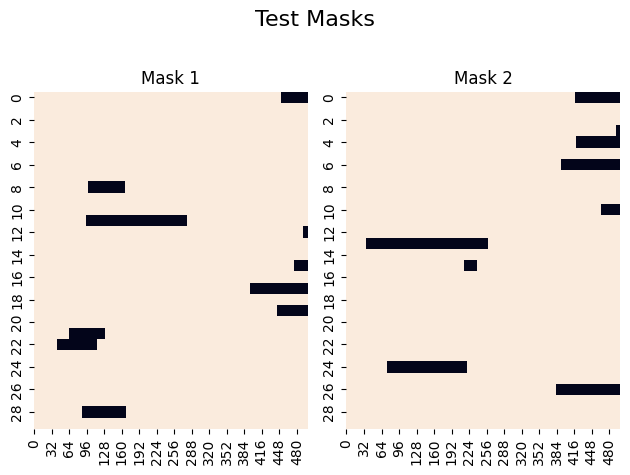

In [ ]:
fig, axes = plt.subplots(1,2)  # axes is a 2D array with shape (2, 3)
axes = axes.flatten()

fig.suptitle("Test Masks", fontsize=16)

# Plot each heatmap
for i, ax in enumerate(axes):
    sns.heatmap(mask_test[i].T, ax=ax, cbar=False)  # Transpose if needed
    ax.set_title(f"Mask {i + 1}")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the overall title

# Show the plots
plt.show()

Velocity for the first 6 sensors (from sensor 0 to sensor 5), red areas represent missing values of the velocity

# Create Train data

In [ ]:
def get_A_hat(adj):
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)

  # computing D_tilde, D_tilde_inv and D_tilde_inv**(1/2)
  A_bin = A_tilde.clone()
  A_bin[A_bin!=0] = 1
  D_tilde = np.array(torch.diag(torch.sum(A_bin, axis = 1)))
  D_tilde_inv = np.linalg.inv(D_tilde)
  D_tilde_inv_sqrt = np.sqrt(D_tilde_inv)
  D_tilde_inv_sqrt[~np.isfinite(D_tilde_inv_sqrt)] = 0
  D_tilde_inv_sqrt = torch.tensor(D_tilde_inv_sqrt, dtype = torch.float32)

  # final adjacency matrix
  A_hat = D_tilde_inv_sqrt@A_tilde@D_tilde_inv_sqrt

  return A_hat



In [ ]:
def create_train_data(data, A, masks):

  #vel = data_tot[:,:,-1].reshape(500,30)

  results_dict = {"A_list":[],
                  "velocity_list":[],
                  "mask_list":[],
                  "masked_nodes":[],
                  "unmasked_nodes":[]}

  for single_mask in masks:

      mask = [torch.tensor(single_mask[tt,:], dtype = torch.float32) for tt in range(single_mask.shape[0])]
      masked_nodes = [np.where(mask[tt]==0)[0] for tt in range(single_mask.shape[0])]
      unmasked_nodes = [np.where(~np.isin(np.arange(len(x_node)), mm))[0] for mm in masked_nodes]

      # #obscured_node_index = [np.where(np.array(mask[i])==-float("Inf"))[0] for i in range(len(t))]

      A_list = []
      mask_list = []

      velocity_temp = data.clone()
      A_temp = A.clone()

      #inductive nodes, I remove masked nodes. Note that the weight matrix in message passing does not depend on the number of nodes, so I can learn it on a graph with N nodes and test it on a graph with N2 nodes

      for i in range(len(mask)):

            m = mask[i]

            A_temp = A_temp*m*m.unsqueeze(1) # set the corresponding row and column of masked index to zero in order to detach the node with missing values from the graph
            A_temp[masked_nodes[i],masked_nodes[i]] = A[masked_nodes[i],masked_nodes[i]] # allow self loop even to nodes with missing values

            A_hat = get_A_hat(A_temp)

            velocity_temp[i,masked_nodes[i]]=0  # missing velocities set to zero


            mask[i][masked_nodes[i]] = -float("Inf")  # nodes with missing velocities set to -Inf

            A_list.append(A_hat)
            mask_list.append(mask[i])


      results_dict["A_list"].append([a.float() for a in A_list])
      results_dict["velocity_list"].append(velocity_temp.float())
      results_dict["mask_list"].append([m.float() for m in mask_list])
      results_dict["masked_nodes"].append(masked_nodes)
      results_dict["unmasked_nodes"].append(unmasked_nodes)

  return results_dict

In [ ]:
np.random.seed(42)

# combination position and time
T,X = np.meshgrid(t, x_node)

#data_vel = standard_scaler(torch.tensor(velocity, dtype = torch.float32).transpose(0,1))
data_vel = torch.tensor(velocity, dtype = torch.float32)
#data_tot = torch.tensor((T,X, data_vel.T), dtype = torch.float32).transpose(1,2).transpose(0,1).transpose(1,2)
#data_tot = torch.cat((data_tot, fft_tensor), dim = 2)
#data_tot = torch.tensor((T,X), dtype = torch.float32).transpose(1,2).transpose(0,1).transpose(1,2)

out_data_train = create_train_data(data_vel, torch.tensor(A), mask_train)
out_data_test = create_train_data(data_vel, torch.tensor(A), mask_test)

<ipython-input-50-10f99da6da0f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = [torch.tensor(single_mask[tt,:], dtype = torch.float32) for tt in range(single_mask.shape[0])]
<ipython-input-47-b9855a1932ce>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)


velocity with missing values

<Axes: >

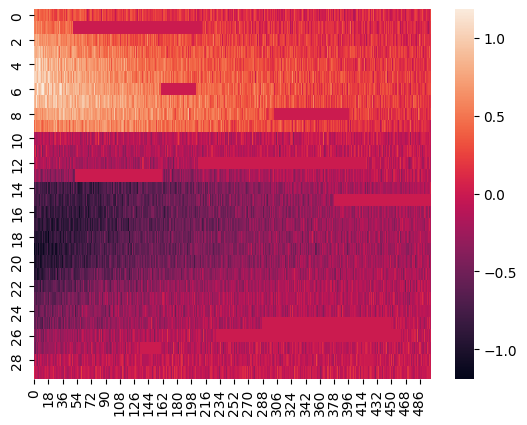

In [ ]:
sns.heatmap(out_data_train["X_list"][1].T)

# Architecture

In [ ]:
def pad_with_last_val(vect, k):
    device = vect.device  # Get device directly from tensor
    pad = torch.ones(k - vect.size(0),
                    dtype=torch.long,
                    device=device) * vect[-1]
    vect = torch.cat([vect, pad])
    return vect

# Fix the pad_with_zeros function similarly
def pad_with_zeros(vect, n):
    device = vect.device  # Get device directly from tensor
    pad = torch.zeros(n - vect.size(0),
                     dtype=torch.long,
                     device=device)
    vect = torch.cat([vect, pad])
    return vect

class Namespace(object):
    '''
    helps referencing object in a dictionary as dict.key instead of dict['key']
    '''
    def __init__(self, adict):
        self.__dict__.update(adict)


class EGCN(torch.nn.Module):
    def __init__(self, args, activation, device='cpu', skipfeats=False):
        super().__init__()
        GRCU_args = Namespace({})

        feats = [args.feats_per_node,
                 args.layer_1_feats,
                 #args.layer_2_feats,
                #  args.layer_3_feats]
        ]
        self.device = device
        self.skipfeats = skipfeats

        self.GRCU_layers = nn.ModuleList()
        for i in range(1, len(feats)):
            GRCU_args = Namespace({'in_feats': feats[i - 1],
                                   'out_feats': feats[i],
                                   'activation': activation})

            grcu_i = GRCU(GRCU_args)
            self.GRCU_layers.append(grcu_i.to(self.device))

    def forward(self, A_list, Nodes_list, nodes_mask_list):
        node_feats = Nodes_list[-1]

        for unit in self.GRCU_layers:
            Nodes_list, weights = unit(A_list, Nodes_list, nodes_mask_list)

        if self.skipfeats:
            out = torch.cat((Nodes_list[-1], node_feats), dim=1)  # Use `node_feats.to_dense()` if 2-hot encoded input
        return Nodes_list, weights

class GRCU(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        cell_args = Namespace({})
        cell_args.rows = args.in_feats
        cell_args.cols = args.out_feats

        self.evolve_weights = mat_GRU_cell(cell_args)

        self.activation = self.args.activation
        self.GCN_init_weights = Parameter(torch.Tensor(self.args.in_feats,self.args.out_feats))
        self.reset_param(self.GCN_init_weights)


    def reset_param(self,t):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(t.size(1))
        t.data.uniform_(-stdv,stdv)

    def forward(self,A_list,node_embs_list,mask_list):
        GCN_weights = self.GCN_init_weights
        out_seq = []
        weights = []
        for t,Ahat in enumerate(A_list):
            node_embs = node_embs_list[t]
            #first evolve the weights from the initial and use the new weights with the node_embs

            GCN_weights = self.evolve_weights(GCN_weights,node_embs,mask_list[t])

            weights.append(GCN_weights.detach().cpu().numpy())

            node_embs = self.activation(Ahat.matmul(node_embs.matmul(GCN_weights)))

            out_seq.append(node_embs)

        return out_seq, weights

class mat_GRU_cell(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        self.update = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.reset = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.htilda = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.ReLU())

        self.choose_topk = TopK(feats = args.rows,
                                k = args.cols )

    def forward(self,prev_Q,prev_Z,mask):
        z_topk = self.choose_topk(prev_Z,mask)

        update = self.update(z_topk,prev_Q)
        reset = self.reset(z_topk,prev_Q)

        h_cap = reset * prev_Q
        h_cap = self.htilda(z_topk, h_cap)

        new_Q = (1 - update) * prev_Q + update * h_cap

        return new_Q



class mat_GRU_gate(torch.nn.Module):
    def __init__(self,rows,cols,activation):
        super().__init__()
        self.activation = activation
        #the k here should be in_feats which is actually the rows
        self.W = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.W)

        self.U = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.U)

        self.bias = Parameter(torch.zeros(rows,cols))

    def reset_param(self,par):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(par.size(1))
        par.data.uniform_(-stdv,stdv)

    def forward(self,x,hidden):
        out = self.activation(self.W.matmul(x) + \
                              self.U.matmul(hidden) + \
                              self.bias)

        return out

class TopK(torch.nn.Module):
    def __init__(self,feats,k):
        super().__init__()
        self.scorer = Parameter(torch.Tensor(feats,1))
        self.reset_param(self.scorer)

        self.k = k

    def reset_param(self,par):
        #Initialize based on the number of rows
        stdv = 1. / math.sqrt(par.size(0))
        par.data.uniform_(-stdv,stdv)


    def forward(self, node_embs, mask):
        # # Compute scores

        scores = node_embs.matmul(self.scorer) / self.scorer.norm()
        scores = scores + mask.view(-1, 1)
        num_nodes = node_embs.size(0)

        if self.k <= num_nodes:
            vals, topk_indices = scores.view(-1).topk(self.k)
            topk_indices = topk_indices[vals > -float("Inf")]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]

        else:
            vals, topk_indices = scores.view(-1).topk(num_nodes)
            valid_mask = vals > -float("Inf")
            topk_indices = topk_indices[valid_mask]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]
            remaining_k = self.k - topk_indices.size(0)

            if remaining_k > 0:
                vals, sorted_indices = scores.view(-1).sort(descending=True)
                valid_mask = vals > -float("Inf")
                sorted_indices = sorted_indices[valid_mask]

                if remaining_k <= num_nodes:
                    repeat_indices = sorted_indices[:remaining_k]
                else:
                    repeat_times = (remaining_k + num_nodes - 1) // num_nodes
                    repeat_indices = sorted_indices.repeat(repeat_times)[:remaining_k]

                if repeat_indices.size(0) < remaining_k:
                    repeat_indices = pad_with_last_val(repeat_indices, remaining_k)

                repeated_nodes = node_embs[repeat_indices]
                repeated_scores = scores[repeat_indices]

                selected_nodes = torch.cat([selected_nodes, repeated_nodes], dim=0)
                selected_scores = torch.cat([selected_scores, repeated_scores], dim=0)

        tanh = torch.nn.Tanh()
        out = selected_nodes * tanh(selected_scores.view(-1, 1))
        return out.t()


class PredictionEGCN(nn.Module):
    def __init__(self, args, activation, n_nodes, device):
        super().__init__()

        self.args = args
        self.device = device
        self.n_nodes = n_nodes
        self.embedding = EGCN(args, activation, device)

        # Increased network capacity with attention and skip connections
        hidden_dim = self.args.layer_1_feats * self.n_nodes

        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Dropout(0.2),
                                                             nn.Linear(128, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Dropout(0.2),
                                                             nn.Linear(128,30, bias = True)) for _ in range(len(t))])

    def forward(self, A_list, g, vel, nodes_mask_list):

        dummy_mask = torch.stack(nodes_mask_list)
        dummy_mask[dummy_mask==-float("Inf")] = 0
        time_size = len(A_list)
        gg = torch.cat((g.reshape(time_size,30,2), vel.reshape(-1,1).reshape(time_size,30,1), dummy_mask.reshape(-1,1).reshape(time_size,30,1)), dim = 2)
        Nodes_list = [g for g in gg]
        final_embed, weights = self.embedding(A_list, Nodes_list, nodes_mask_list)
        prediction_for_each_t = []


        # Process each timestep
        for i in range(len(final_embed)):
            embed = final_embed[i]
            embed = embed.flatten().unsqueeze(0)
            pred = self.node_specific_nn[i](embed).reshape(-1)
            prediction_for_each_t.append(pred)

        return prediction_for_each_t, weights


class PredictionReadOut(nn.Module):
    def __init__(self, args, n_nodes, device):
        super().__init__()

        self.args = args
        self.device = device
        self.n_nodes = n_nodes

        hidden_dim = self.args.feats_per_node * self.n_nodes

        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Linear(128, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Linear(128,30, bias = True)) for _ in range(len(t))])

        def forward(self, A_list, g, vel, nodes_mask_list):

            dummy_mask = torch.stack(nodes_mask_list)
            dummy_mask[dummy_mask==-float("Inf")] = 0
            gg = torch.cat((g.reshape(500,30,2), vel.reshape(-1,1).reshape(500,30,1), dummy_mask.reshape(-1,1).reshape(500,30,1)), dim = 2)
            Nodes_list = [g for g in gg]
            prediction_for_each_t = []


            # Process each timestep
            for i in range(len(Nodes_list)):
                embed = Nodes_list[i]
                embed = embed.flatten().unsqueeze(0)
                pred = self.node_specific_nn[i](embed).reshape(-1)
                prediction_for_each_t.append(pred)

            return prediction_for_each_t


# Training

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 4,
        'layer_1_feats': 16,
        }) # output dim

activation = nn.ReLU()

print("Running training...")

tt = torch.tensor(t, dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g = torch.stack(torch.meshgrid(tt, xx)).reshape(2,-1).T.requires_grad_(True).to(device)

for i in range(train_size):

    out_data_train["A_list"][i] = [a.to(device) for a in out_data_train["A_list"][i]]
    out_data_train["mask_list"][i] = [m.to(device) for m in out_data_train["mask_list"][i]]
    out_data_train["velocity_list"][i] = out_data_train["velocity_list"][i].to(device)

data_vel = data_vel.to(device)

#data_tot = data_tot.to(device)

n_nodes = len(x_node)

# Move model to device
model = PredictionEGCN(args_dict, activation, n_nodes, device).to(device)


#model = simpleNN(args_dict, activation, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 30

lambda_physics = 0.5

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []
data_missing = []

nu = 0.1

predictions = [0]*train_size
weights = [0]*train_size


for epoch in range(n_epochs):
    epoch_loss = 0

    data_missing_loss_train = 0
    data_available_loss_train = 0

    for i in range(train_size):

        optimizer.zero_grad()

        predictions[i], weights[i] = model.forward(out_data_train["A_list"][i], g, out_data_train["velocity_list"][i], out_data_train["mask_list"][i])

        uu = torch.stack(predictions[i]).reshape(-1)

        du_dg = torch.autograd.grad(
              inputs=g,
              outputs=uu,
              grad_outputs=torch.ones_like(uu),
              retain_graph=True,
              create_graph=True
          )[0]

        du_dt = du_dg[:,0]
        du_dx = du_dg[:,1]

        du_dxx = torch.autograd.grad(
              inputs=g,
              outputs=du_dg,
              grad_outputs=torch.ones_like(du_dg),
              retain_graph=True,
              create_graph=True
          )[0][:, 0]



        f = uu*du_dx + du_dt - nu*du_dxx

        physics_loss = F.mse_loss(f,torch.zeros_like(f))


        data_loss = 0
        missing_train = 0
        available_train = 0
        count_missing = 0
        count_available = 0

        for j in range(len(t)):

            mask = out_data_train["mask_list"][i][j].clone()
            mask[mask==-float("Inf")]=0

            data_loss += F.mse_loss(predictions[i][j],data_vel[j,:])

            if len(torch.where(mask == 0)[0]) != 0:
              missing_train += F.mse_loss(predictions[i][j][mask==0],data_vel[j,mask==0])
              count_missing += 1

            if len(torch.where(mask == 1)[0]) != 0:
              available_train += F.mse_loss(predictions[i][j][mask==1],data_vel[j,mask==1])
              count_available += 1

        data_mean_loss = data_loss/len(t)
        data_missing_loss_train += missing_train/max(1,count_missing)
        data_available_loss_train += available_train/max(1,count_available)

        total_loss = data_mean_loss * (1-lambda_physics) + physics_loss*lambda_physics

        # train_data_loss.append(data_mean_loss.detach().item())
        # train_loss.append(total_loss.detach().item())
        # data_missing.append(data_missing_loss.detach().item())

        total_loss.backward()
        optimizer.step()

    #epoch_loss += data_mean_loss.item()

    data_missing_loss_train = data_missing_loss_train/train_size
    data_available_loss_train = data_available_loss_train/train_size

    if epoch % 2 == 0:
        #print(f"Epoch {epoch}, Data Loss: {data_mean_loss.item():.6f}, physic_loss: {physics_loss.item()}") #, Physic Loss: {loss_pde.item()}, total loss: {total_loss.item()}")
        print(f"Epoch {epoch}, Data Loss: {data_mean_loss.item():.6f}, Error on missing: {data_missing_loss_train:.6f}, Error on available: {data_available_loss_train:.6f}") #, Physic Loss: {loss_pde.item()}, total loss: {total_loss.item()}")

Running training...
Epoch 0, Data Loss: 0.025885, Error on missing: 0.048146, Error on available: 0.057435
Epoch 2, Data Loss: 0.007028, Error on missing: 0.007830, Error on available: 0.009278
Epoch 4, Data Loss: 0.003863, Error on missing: 0.003595, Error on available: 0.004437
Epoch 6, Data Loss: 0.002539, Error on missing: 0.002216, Error on available: 0.002710
Epoch 8, Data Loss: 0.002285, Error on missing: 0.001799, Error on available: 0.002225
Epoch 10, Data Loss: 0.001669, Error on missing: 0.001552, Error on available: 0.001855
Epoch 12, Data Loss: 0.001704, Error on missing: 0.001319, Error on available: 0.001533
Epoch 14, Data Loss: 0.001532, Error on missing: 0.001266, Error on available: 0.001541
Epoch 16, Data Loss: 0.001511, Error on missing: 0.001150, Error on available: 0.001377
Epoch 18, Data Loss: 0.001279, Error on missing: 0.001033, Error on available: 0.001212
Epoch 20, Data Loss: 0.001373, Error on missing: 0.000997, Error on available: 0.001213
Epoch 22, Data Lo

# Results

In [ ]:

data_test = 0
data_missing_test_loss = 0
data_available_test_loss = 0


for i in range(test_size):

    out_data_test["A_list"][i] = [a.to(device) for a in out_data_test["A_list"][i]]
    out_data_test["mask_list"][i] = [m.to(device) for m in out_data_test["mask_list"][i]]
    out_data_test["velocity_list"][i] = out_data_test["velocity_list"][i].to(device)

predictions_test = [0]*test_size
weights_test = [0]*test_size

with torch.no_grad():
    model.eval()

    for i in range(test_size):
        A_list = out_data_test["A_list"][i]
        mask_list = out_data_test["mask_list"][i]
        vel = out_data_test["velocity_list"][i]

        predictions_test[i], weights_test[i] = model.forward(A_list, g, vel, mask_list)

        missing_test = 0
        available_test = 0
        count_missing = 0
        count_available = 0

        for j in range(len(t)):

          mask = mask_list[j].clone()
          mask[mask==-float("Inf")]=0

          if len(torch.where(mask == 0)[0]) != 0:
            missing_test += F.mse_loss(predictions_test[i][j][mask==0],data_vel[i,mask==0])
            count_missing += 1

          if len(torch.where(mask == 1)[0]) != 0:
            available_test += F.mse_loss(predictions_test[i][j][mask==1],data_vel[i,mask==1])
            count_available += 1

        data_missing_test_loss += missing_test/count_missing
        data_available_test_loss += available_test/count_available


    data_missing_test_loss = data_missing_test_loss/test_size
    data_available_test_loss = data_available_test_loss/test_size
        #data_test_loss = data_test/len(t)


In [ ]:
error_df = pd.DataFrame({
    "set": ["train", "test"],
    "error on missing data": [data_missing_loss_train.detach().item(), data_missing_test_loss.item()],
    "error on NON missing data": [data_available_loss_train.detach().item(), data_available_test_loss.item()]
    })
error_df.set_index("set", inplace = True)
error_df.head()

,error on missing data,error on NON missing data
set,,
train,0.000711,0.000881
test,0.149011,0.193421


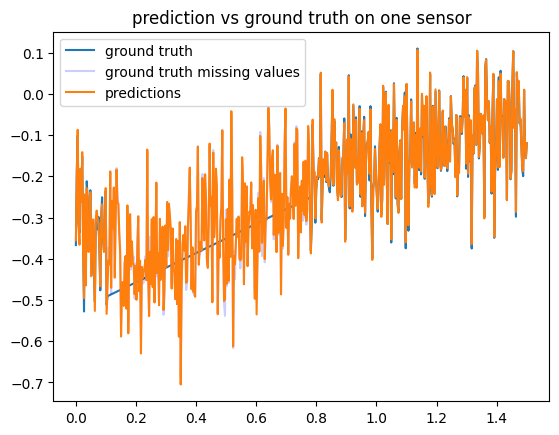

In [ ]:
sen = 13
m = torch.stack(out_data_test["mask_list"][1]).cpu()
pred = torch.stack(predictions_test[1]).cpu()
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = data_vel[:,sen].cpu().detach().numpy()
plt.plot(t[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(t[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", alpha = 0.2, label = "ground truth missing values")
plt.plot(t, pred[:,sen], label = "predictions")
plt.title("prediction vs ground truth on one sensor")
plt.legend()


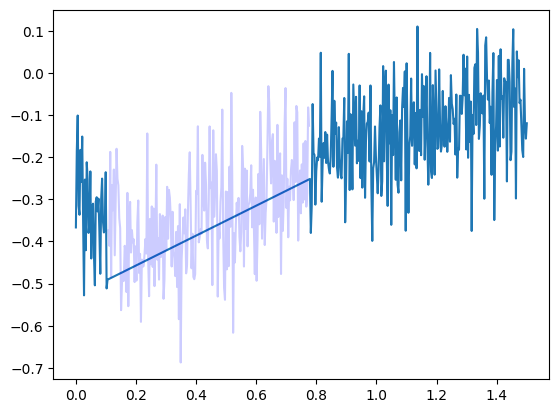

In [ ]:
plt.plot(t[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(t[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", alpha = 0.2, label = "ground truth missing values")

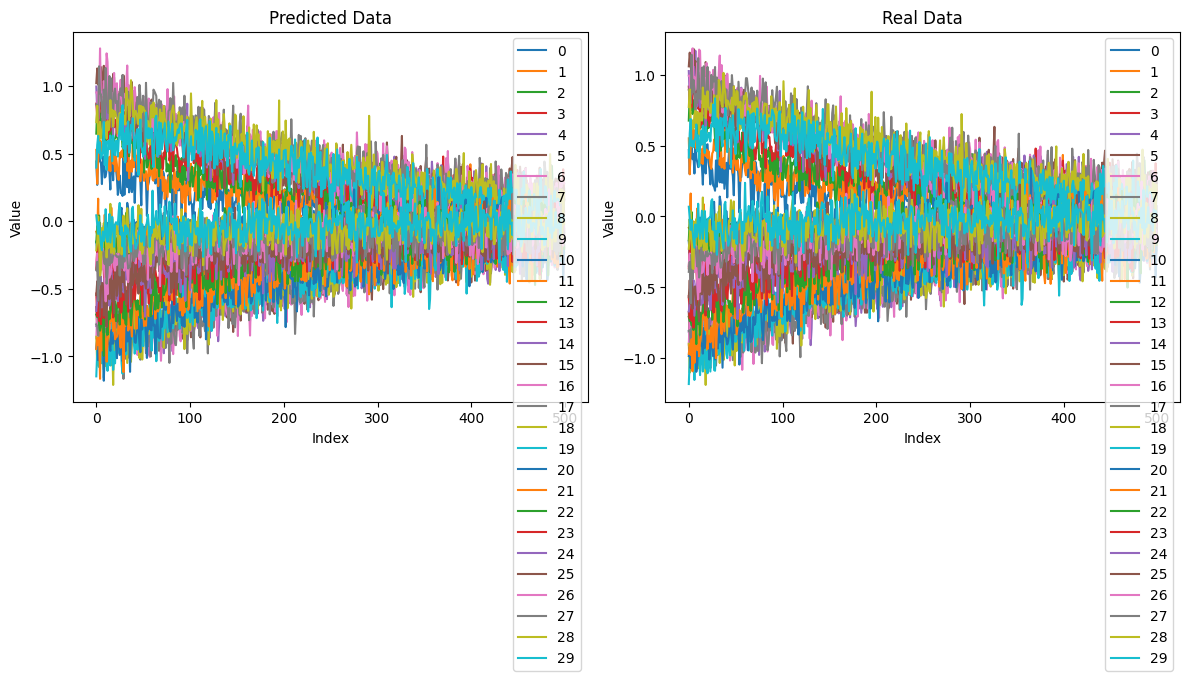

In [ ]:
df_test_pred = pd.DataFrame(pred)  # Replace 'pred' with your predicted data
df_test_real = pd.DataFrame(velocity)  # Replace 'velocity' with your real data

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first DataFrame in the first subplot
df_test_pred.plot(ax=axes[0], title='Predicted Data')
axes[0].set_title('Predicted Data')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')

# Plot the second DataFrame in the second subplot
df_test_real.plot(ax=axes[1], title='Real Data')
axes[1].set_title('Real Data')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

In [ ]:
def plot_3d_solution(x, t, u_pred, u_real):
    """Create multiple 3D visualizations of the solution"""
    # Create a meshgrid for plotting
    X, T = np.meshgrid(x, t)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 7))
    axes = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(2)]

    # Plot predictions and ground truth
    for i, (ax, u) in enumerate(zip(axes, [u_pred, u_real])):
        surf = ax.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(f'Surface Plot: {"Predictions" if i == 0 else "Ground Truth"}')

        # Add colorbar to the side of the respective subplot
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        # Adjust view angles
        ax.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()


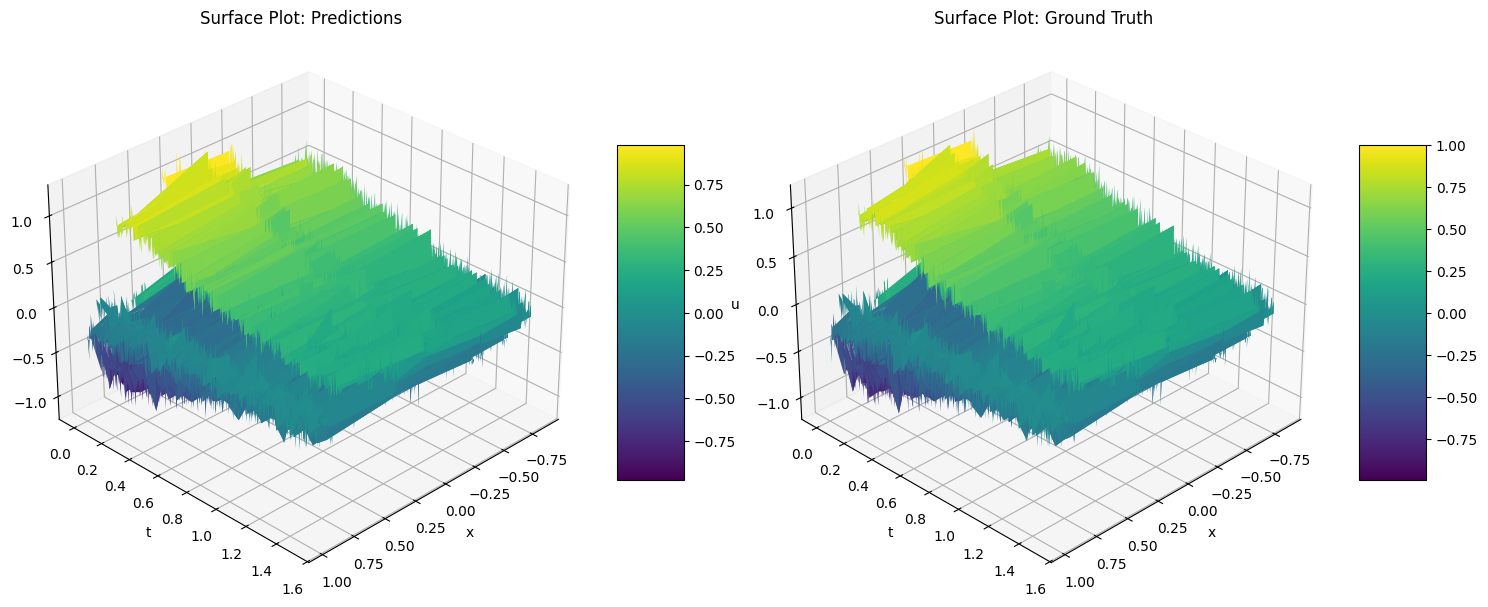

In [ ]:
plot_3d_solution(x_node, t, pred.cpu(), data_vel.cpu())


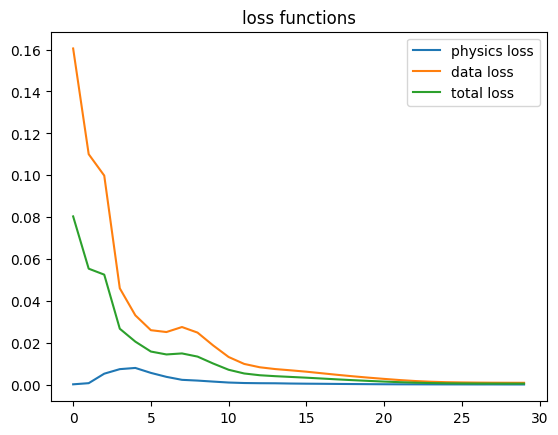

In [ ]:
plt.plot(train_loss_physics, label = "physics loss")
plt.plot(train_data_loss, label = "data loss")
plt.plot(train_loss, label = "total loss")
plt.title("loss functions")
plt.legend()

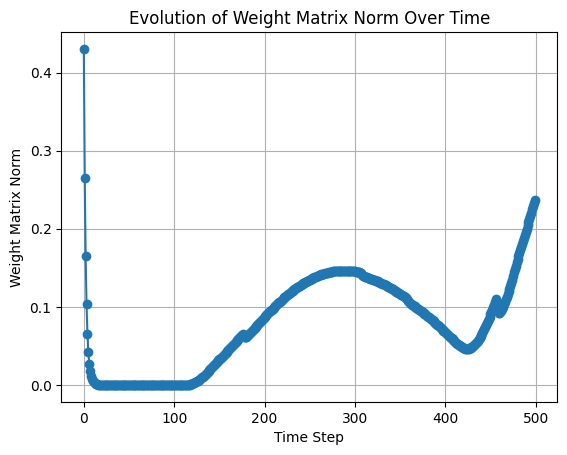

In [ ]:
weights_norms = [np.linalg.norm(weight) for weight in weights]  # Frobenius norm of each matrix

# Plot the norms over time
plt.plot(range(len(weights)), weights_norms, marker='o')
plt.xlabel("Time Step")
plt.ylabel("Weight Matrix Norm")
plt.title("Evolution of Weight Matrix Norm Over Time")
plt.grid(True)
plt.show()

# Predictions without GNN

In [ ]:
class JustReadOut(nn.Module):
    def __init__(self, args, activation, n_nodes, device):
        super().__init__()

        self.args = args
        self.device = device
        self.n_nodes = n_nodes

        # Increased network capacity with attention and skip connections
        hidden_dim = 2 * self.n_nodes

        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Linear(128, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Linear(128,30, bias = True)) for _ in range(len(t))])

    def forward(self, A_list, g, vel, nodes_mask_list):

        # dummy_mask = torch.stack(nodes_mask_list)
        # dummy_mask[dummy_mask==-float("Inf")] = 0
        # gg = torch.cat((g.reshape(500,30,2), vel.reshape(-1,1).reshape(500,30,1), dummy_mask.reshape(-1,1).reshape(500,30,1)), dim = 2)
        gg = g.reshape(500,30,2)
        Nodes_list = [g for g in gg]
        # final_embed, weights = self.embedding(A_list, Nodes_list, nodes_mask_list)
        prediction_for_each_t = []


        # Process each timestep
        for i in range(len(Nodes_list)):
            embed = Nodes_list[i]
            embed = embed.flatten().unsqueeze(0)
            pred = self.node_specific_nn[i](embed).reshape(-1)
            prediction_for_each_t.append(pred)

        return prediction_for_each_t

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 2,
        'layer_1_feats': 16,
        #'layer_2_feats': 64,
        # 'layer_3_feats': 64
        }) # output dim

activation = nn.ReLU()

print("Running training...")

A_list = [a.to(device) for a in out_data[0]]
mask_list = [m.to(device) for m in out_data[2]]
data_vel = data_vel.to(device)

tt = torch.tensor(t, dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g = torch.stack(torch.meshgrid(tt, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel = out_data[1].to(device)

data_tot = data_tot.to(device)

n_nodes = len(x_node)

hidden_dim = args_dict.layer_1_feats * n_nodes
output_dim = n_nodes

# Move model to device
model = JustReadOut(args_dict, activation, n_nodes, device).to(device)


#model = simpleNN(args_dict, activation, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 30

lambda_physics = 0.5

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []
data_missing = []

nu = 0.1


for epoch in range(n_epochs):
    epoch_loss = 0
    predictions_t = []

    optimizer.zero_grad()

    predictions_read_out = model.forward(A_list, g, vel, mask_list)

    uu_ro = torch.stack(predictions_read_out).reshape(-1)

    du_dg = torch.autograd.grad(
          inputs=g,
          outputs=uu_ro,
          grad_outputs=torch.ones_like(uu),
          retain_graph=True,
          create_graph=True
      )[0]

    du_dt = du_dg[:,0]
    du_dx = du_dg[:,1]

    du_dxx = torch.autograd.grad(
          inputs=g,
          outputs=du_dg,
          grad_outputs=torch.ones_like(du_dg),
          retain_graph=True,
          create_graph=True
      )[0][:, 0]



    f = uu*du_dx + du_dt - nu*du_dxx

    physics_loss = F.mse_loss(f,torch.zeros_like(f))

    train_loss_physics.append(physics_loss.detach().item())


    data_loss = 0
    data_missing_loss = 0
    count_missing = 0

    for i in range(len(t)):

      mask = mask_list[i]
      mask[mask==-float("Inf")]=0

      #target = data_vel[i, mask==1].to(device)
      #target = data_vel[i,:]

      data_loss += F.mse_loss(predictions_read_out[i],data_vel[i,:])

      if len(torch.where(mask == 0)[0]) != 0:
        data_missing_loss += F.mse_loss(predictions_read_out[i][mask==0],data_vel[i,mask==0])
        count_missing += 1

    data_mean_loss = data_loss/len(t)
    data_missing_loss = data_missing_loss/count_missing

    total_loss = data_mean_loss * (1-lambda_physics) + physics_loss*lambda_physics

    train_data_loss.append(data_mean_loss.detach().item())
    train_loss.append(total_loss.detach().item())
    data_missing.append(data_missing_loss.detach().item())

    total_loss.backward()
    optimizer.step()

    epoch_loss += data_mean_loss.item()

    if epoch % 2 == 0:
        print(f"Epoch {epoch}, Data Loss: {data_mean_loss.item():.6f}, physic_loss: {physics_loss.item()}") #, Physic Loss: {loss_pde.item()}, total loss: {total_loss.item()}")


Running training...


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.